<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Soft_Computing_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import zipfile
import os

In [7]:
# Doest work
# !wget https://github.com/yeesem/Machine-Learning-Datasets/blob/main/Jute%20Pest%20Dataset.zip

In [8]:
zip_file_name = "/content/Jute Pest Dataset.zip"
zip_ref = zipfile.ZipFile(zip_file_name,'r')
zip_ref.extractall()
zip_ref.close()

In [9]:
# Assign the training and validation set directories
base_dir = '/content/jute_insect_data_all'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

full_form_insect = os.listdir(train_dir)
short_form_insect = [''.join([item[0].lower() for item in name.split(" ")]) for name in full_form_insect]
insect_type_dict = {}

train_dirs = {}
validation_dirs = {}

for insect_type,insect_type_short_form in zip(full_form_insect,short_form_insect):
  insect_type_dict[insect_type_short_form] = insect_type
  train_dirs[insect_type_short_form] = os.path.join(train_dir,insect_type)
  validation_dirs[insect_type_short_form] = os.path.join(validation_dir,insect_type)

In [10]:
# Number of each training and validation set
for insect_short_form, dir in insect_type_dict.items():
  print(insect_type_dict[insect_short_form])
  print("Number of training sets   : ",len(os.listdir(train_dirs[insect_short_form])))
  print("Number of validation sets : ",len(os.listdir(validation_dirs[insect_short_form])))
  print('\n')

Field Cricket
Number of training sets   :  220
Number of validation sets :  30


Yellow Mite
Number of training sets   :  220
Number of validation sets :  30


Spilosoma Obliqua
Number of training sets   :  220
Number of validation sets :  30


Jute Stem Weevil
Number of training sets   :  220
Number of validation sets :  30




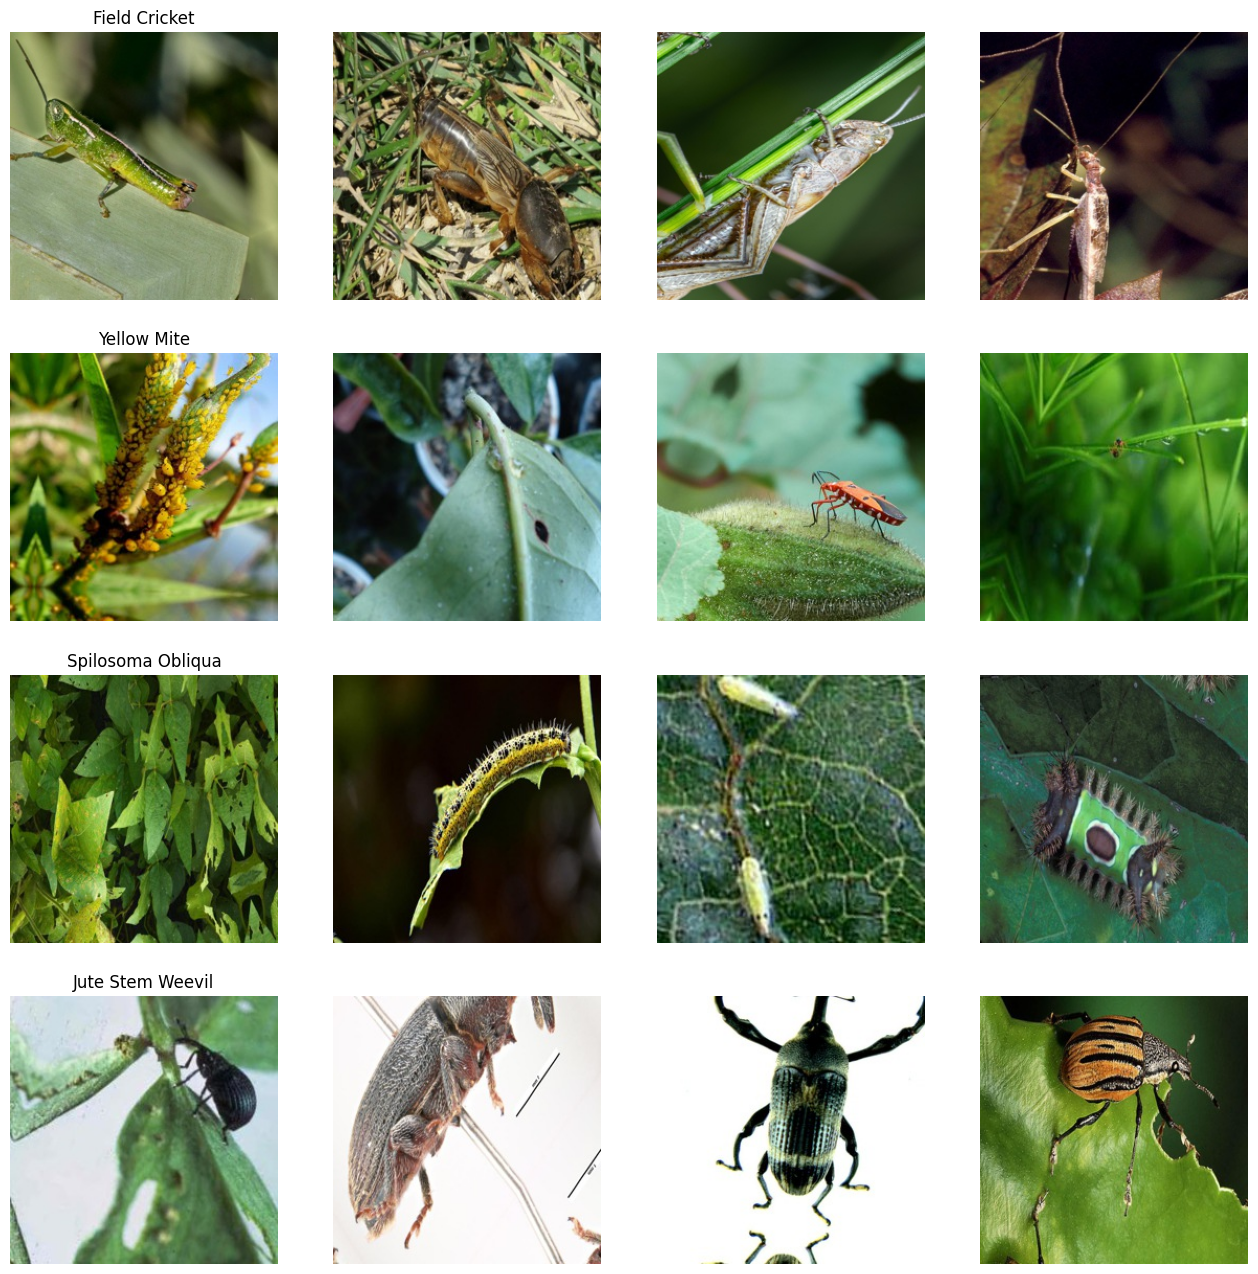

In [11]:
# Set up matplotlib fig and size it to fit 4x4 pics
ncols = 4
nrows = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4,nrows * 4)

pic_index += 4

insect_pix = []

for insect_type in train_dirs:
    insect_pix.extend(os.path.join(train_dirs[insect_type],fname)
                      for fname in os.listdir(train_dirs[insect_type])[pic_index-4:pic_index])

for i, img_path in enumerate(insect_pix):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

  # Add title for each row
  if i % ncols == 0:
      row_title_index = i // ncols
      plt.title(full_form_insect[row_title_index])

plt.show()

# **Tensorflow and Keras**

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def DataGenerator(train_directory,validation_directory,DataAugmentation = False,size = 250):

  if DataAugmentation == False:
    train_datagen = ImageDataGenerator(rescale = 1./255)

  else:
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
    )

  test_datagen = ImageDataGenerator(rescale = 1./255)

  train_data_generator = train_datagen.flow_from_directory(
      train_directory,
      target_size = (size,size),
      batch_size = 16,
      class_mode = 'categorical'
  )

  test_data_generator = test_datagen.flow_from_directory(
      validation_directory,
      target_size = (size,size),
      batch_size = 4,
      class_mode = 'categorical'
  )

  return train_data_generator,test_data_generator

In [13]:
def create_model(model_type = 'COMPLEX',size = 250,dropout = False, DROPOUT_RATE = 0.0):
  if model_type == 'SIMPLE':
      model = tf.keras.models.Sequential([
          # First Convolutional layer
          tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',input_shape = (size,size,3)),
          tf.keras.layers.MaxPooling2D((2,2)),

          # Connected layer
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128,activation = 'relu'),
          tf.keras.layers.Dense(4,activation = 'softmax'),
      ])

  elif model_type == 'MEDIUM':
    model = tf.keras.models.Sequential([
        # First Convolutional layer
        tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',input_shape = (size,size,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        # Second Convolutional layer
        tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        # Connected layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dropout(DROPOUT_RATE) if dropout else tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(32,activation = 'relu'),
        tf.keras.layers.Dense(4,activation = 'softmax'),
    ])



  elif model_type == 'COMPLEX':
      model = tf.keras.models.Sequential([
          # First Convolutional layer
          tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (size,size,3)),
          tf.keras.layers.MaxPooling2D((2,2)),
          # Second Convolutional layer
          tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
          tf.keras.layers.MaxPooling2D((2,2)),
          # Third Convolutional layer
          tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
          tf.keras.layers.MaxPooling2D((2,2)),
          # Forth Convolutional layer
          tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
          tf.keras.layers.MaxPooling2D((2,2)),

          # Connected layer
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128,activation = 'relu'),
          tf.keras.layers.Dropout(DROPOUT_RATE) if dropout else tf.keras.layers.Dropout(0),
          tf.keras.layers.Dense(32,activation = 'relu'),
          tf.keras.layers.Dense(4,activation = 'softmax'),
      ])

  return model

In [14]:
def compile_model(model,loss = 'categorical_crossentropy',optimizer = tf.keras.optimizers.Adam,learning_rate = 0.0001):
  model.compile(
      loss = loss,
      optimizer = optimizer(learning_rate = learning_rate),
      metrics = ['accuracy']
  )

In [15]:
def fit_model(model,train_data_generator,validation_data_generator,num_epochs,verbose):
  history = model.fit(
      train_data_generator,
      epochs = num_epochs,
      steps_per_epoch = 55,
      validation_data = validation_data_generator,
      validation_steps = 30,
      verbose = verbose
  )

  return history

In [16]:
def plot_graphs(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss =  history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
  plt.plot(epochs,val_acc,'r',label = 'Testing Accuracy')
  plt.title("Training and Testing Accuracy")
  plt.figure()

  plt.plot(epochs,loss,'bo',label = 'Training Loss')
  plt.plot(epochs,val_loss,'r',label = 'Testing Loss')
  plt.title("Training and Testing Loss")
  plt.legend()
  plt.show()

In [17]:
def train_model(train_dir,validation_dir,setting):

  MODEL_TYPE = setting[0]
  TARGET_SIZE = setting[1]
  IMAGE_AUGMENTATION = setting[2]
  DROPOUT = setting[3]
  DROPOUT_RATE =setting[4]
  NUM_EPOCHS = setting[5]
  LEARNING_RATE = setting[6]
  OPTIMIZER = tf.keras.optimizers.Adam
  VERBOSE = 0

  # Image Generator
  train_generator,validation_generator = DataGenerator(train_dir,validation_dir,IMAGE_AUGMENTATION,TARGET_SIZE)

  # Create model
  model = create_model(MODEL_TYPE,TARGET_SIZE, DROPOUT, DROPOUT_RATE)

  # Compile model
  compile_model(model,optimizer = OPTIMIZER,learning_rate = LEARNING_RATE)

  # Train model
  history = fit_model(model,train_generator,validation_generator,NUM_EPOCHS,verbose = VERBOSE)

  # Plot Accuracy and Loss graph
  plot_graphs(history)

  return history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1],history.history['val_loss'][-1]

In [4]:
def compare_model(settings):
    acc_list = []
    loss_list = []

    for index,setting in enumerate(settings):
      print((index + 1)," : ",setting)
      print("\n")
      acc,val_acc,loss,val_loss = train_model(train_dir,validation_dir,setting)

      acc_list.append([acc,val_acc])
      loss_list.append([loss,val_loss])
      print("\n")

    print("--- Model Performance ---")
    for index,setting in enumerate(settings):
      print(setting)
      print("Acc      : ",acc_list[index][0])
      print("Val Acc  : ",acc_list[index][1])
      print("Loss     : ",loss_list[index][0])
      print("Val Loss : ",loss_list[index][1])
      print("\n")

# Architecture Comparison

1  :  ['SIMPLE', 150, False, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


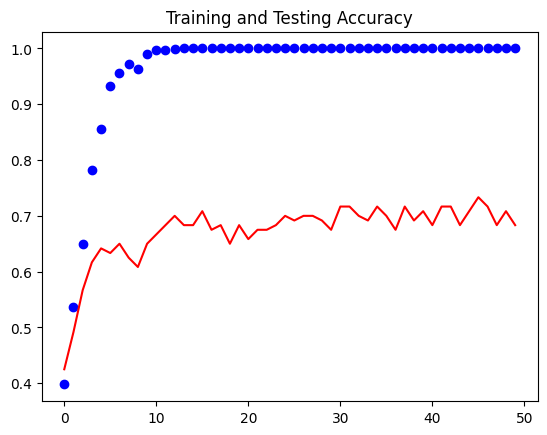

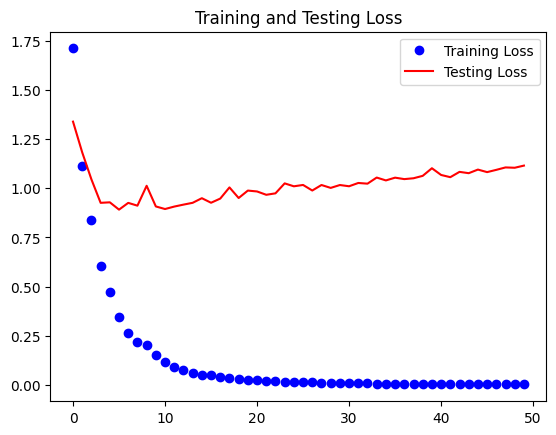



2  :  ['MEDIUM', 150, False, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


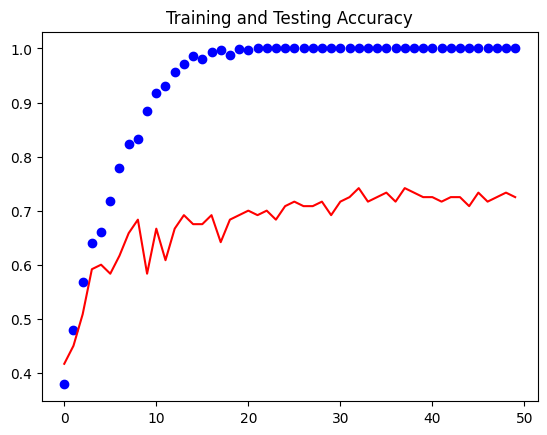

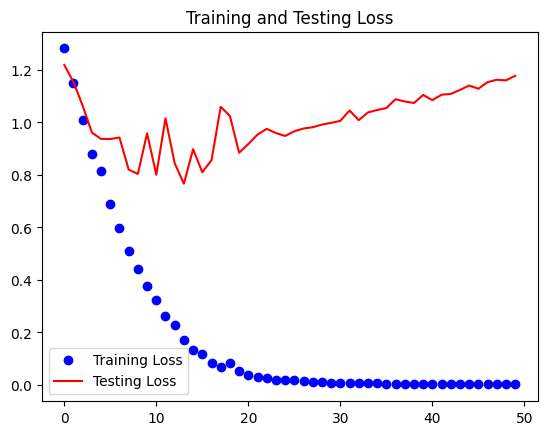



3  :  ['COMPLEX', 150, False, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


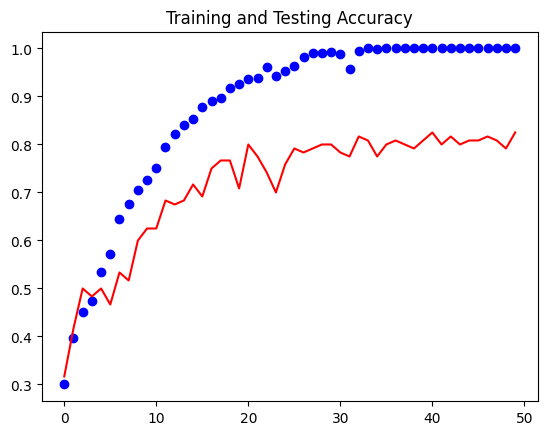

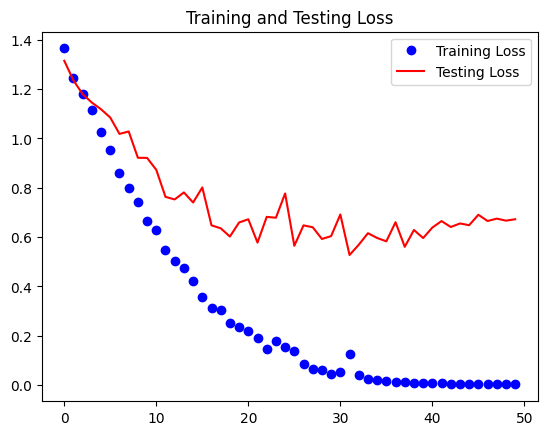



--- Model Performance ---
['SIMPLE', 150, False, False, 0, 50, 0.0001]
Acc      :  1.0
Val Acc  :  0.6833333373069763
Loss     :  0.002526325872167945
Val Loss :  1.115458607673645


['MEDIUM', 150, False, False, 0, 50, 0.0001]
Acc      :  1.0
Val Acc  :  0.7250000238418579
Loss     :  0.0019540477078408003
Val Loss :  1.1776472330093384


['COMPLEX', 150, False, False, 0, 50, 0.0001]
Acc      :  1.0
Val Acc  :  0.824999988079071
Loss     :  0.0029973872005939484
Val Loss :  0.6722155213356018




In [23]:
settings = [
    ['SIMPLE',150,False,False,0,50,0.0001],
    ['MEDIUM',150,False,False,0,50,0.0001],
    ['COMPLEX',150,False,False,0,50,0.0001],
]

compare_model(settings)

# Learning Rate Comparison

1  :  ['COMPLEX', 150, False, False, 0, 50, 0.1]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


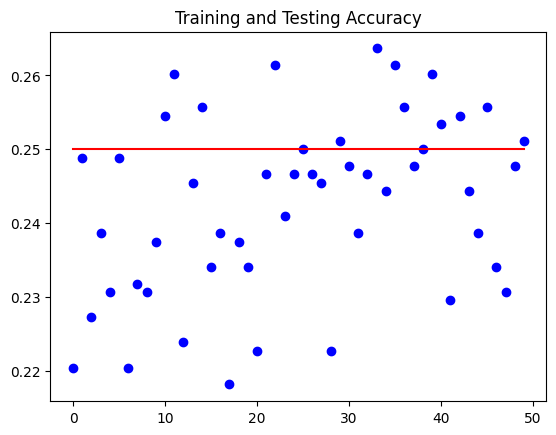

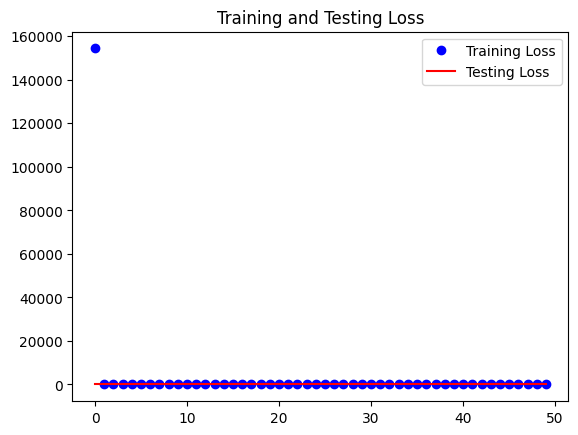



2  :  ['COMPLEX', 150, False, False, 0, 50, 0.01]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


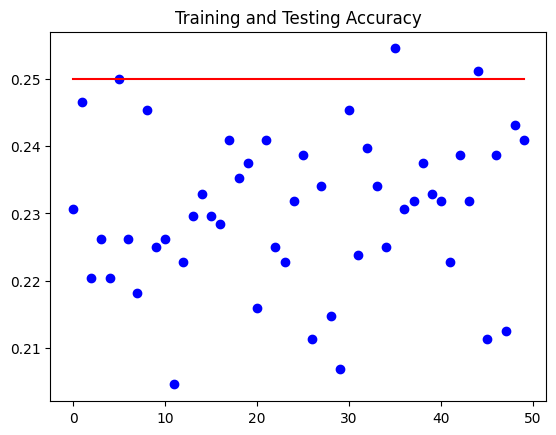

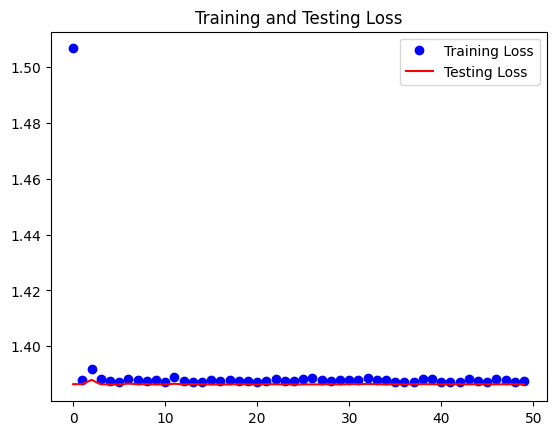



3  :  ['COMPLEX', 150, False, False, 0, 50, 0.001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


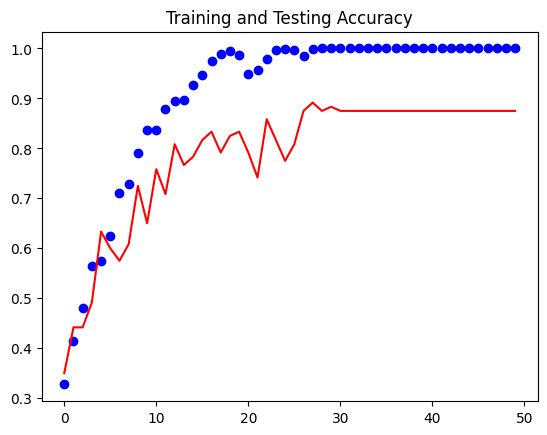

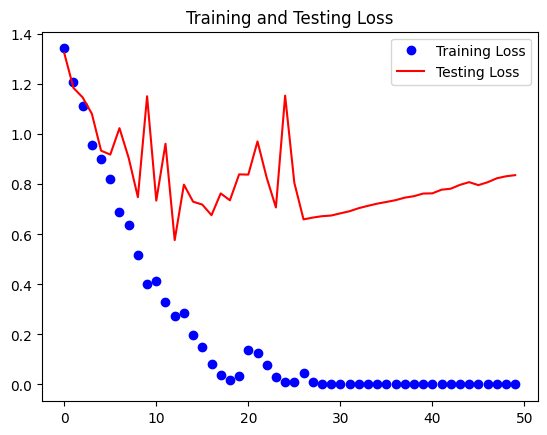



4  :  ['COMPLEX', 50, False, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


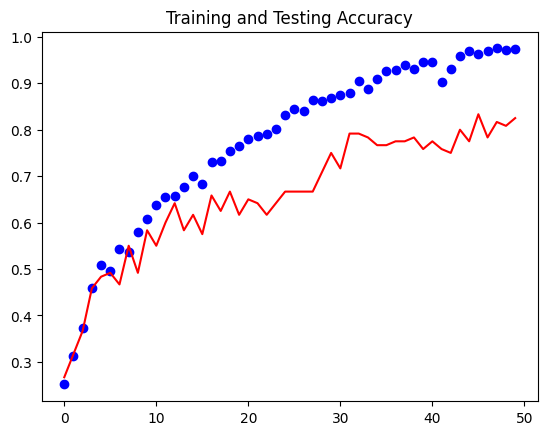

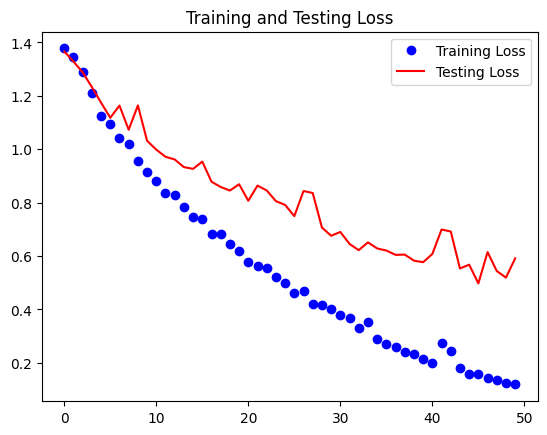



--- Model Performance ---
['COMPLEX', 150, False, False, 0, 50, 0.1]
Acc      :  0.2511363625526428
Val Acc  :  0.25
Loss     :  1.3942139148712158
Val Loss :  1.393074870109558


['COMPLEX', 150, False, False, 0, 50, 0.01]
Acc      :  0.24090908467769623
Val Acc  :  0.25
Loss     :  1.3873850107192993
Val Loss :  1.3863346576690674


['COMPLEX', 150, False, False, 0, 50, 0.001]
Acc      :  1.0
Val Acc  :  0.875
Loss     :  5.307825267664157e-05
Val Loss :  0.8366186618804932


['COMPLEX', 50, False, False, 0, 50, 0.0001]
Acc      :  0.9738636612892151
Val Acc  :  0.824999988079071
Loss     :  0.11879841983318329
Val Loss :  0.5913504958152771




In [23]:
settings = [
    ['COMPLEX', 150, False,  False, 0, 50 ,0.1],
    ['COMPLEX', 150, False,  False, 0, 50 ,0.01],
    ['COMPLEX', 150, False,  False, 0, 50 ,0.001],
    ['COMPLEX', 50, False,  False, 0, 50 ,0.0001]
    ]

compare_model(settings)

# Data Augmentation

1  :  ['COMPLEX', 150, False, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


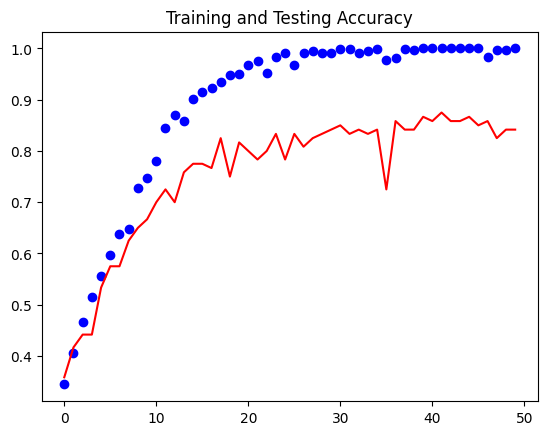

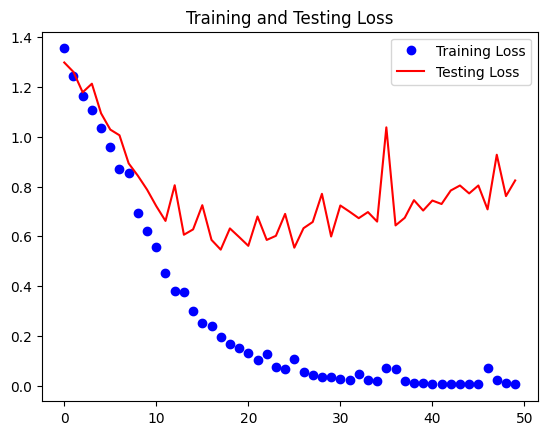



2  :  ['COMPLEX', 150, True, False, 0, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


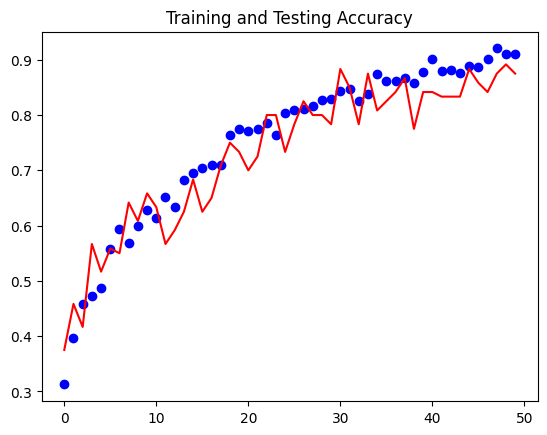

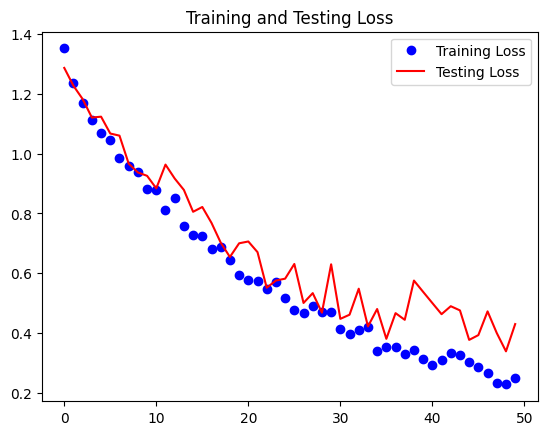



--- Model Performance ---
['COMPLEX', 150, False, False, 0, 50, 0.0001]
Acc      :  1.0
Val Acc  :  0.8416666388511658
Loss     :  0.004683594685047865
Val Loss :  0.8245368599891663


['COMPLEX', 150, True, False, 0, 50, 0.0001]
Acc      :  0.9102272987365723
Val Acc  :  0.875
Loss     :  0.25015318393707275
Val Loss :  0.4302007555961609




In [25]:
settings = [
    ['COMPLEX',150,False,False,0,50,0.0001],
    ['COMPLEX',150,True,False,0,50,0.0001],
]

compare_model(settings)

# Dropout Layer

1  :  ['COMPLEX', 150, True, True, 0.3, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


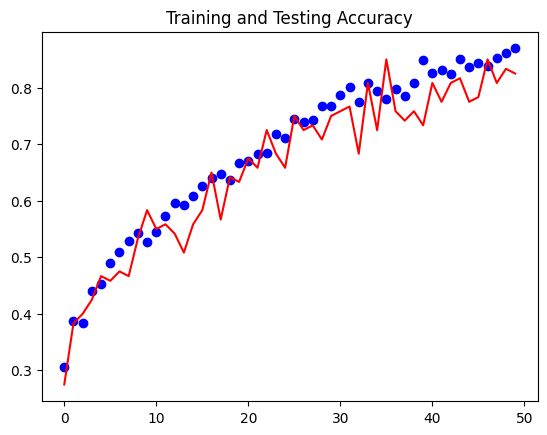

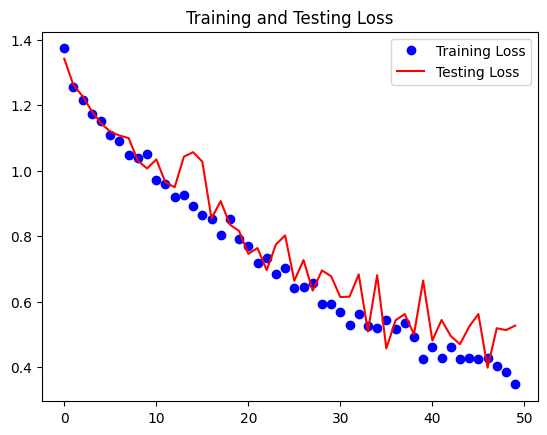



2  :  ['COMPLEX', 150, True, True, 0.5, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
settings = [
    ['COMPLEX',150,True,True,0.3,50,0.0001],
    ['COMPLEX',150,True,True,0.5,50,0.0001],
]

compare_model(settings)

# Image Target Size

1  :  ['COMPLEX', 300, True, True, 0.3, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


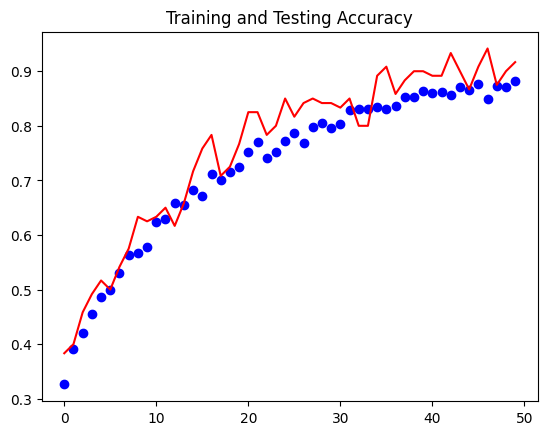

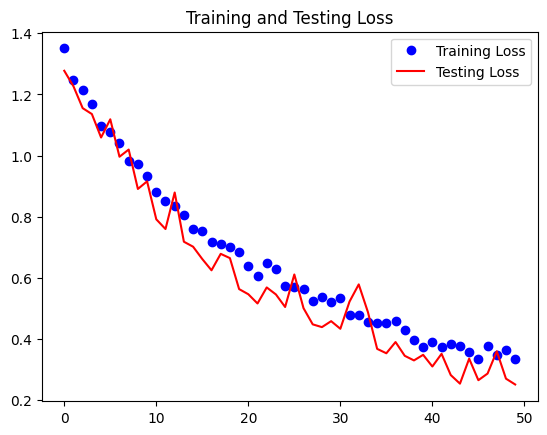



2  :  ['COMPLEX', 500, True, True, 0.3, 50, 0.0001]


Found 880 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


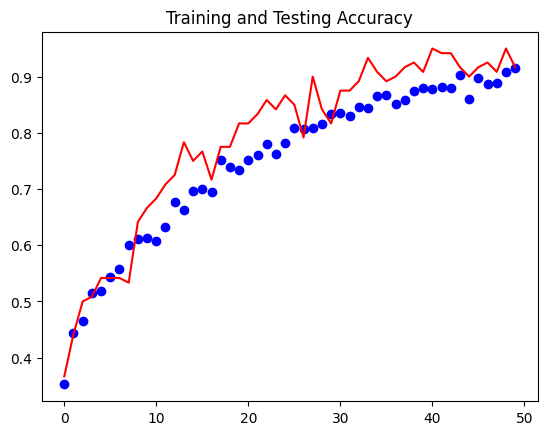

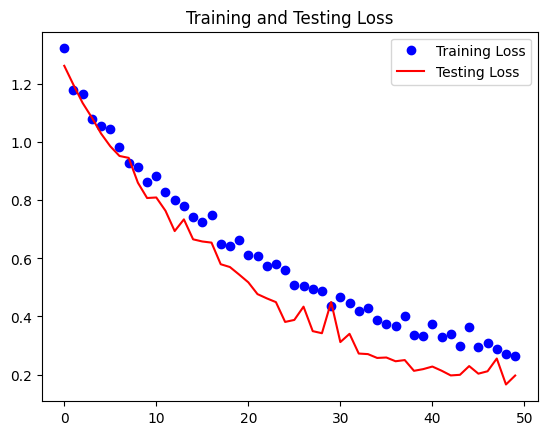



--- Model Performance ---
['COMPLEX', 300, True, True, 0.3, 50, 0.0001]
Acc      :  0.8818181753158569
Val Acc  :  0.9166666865348816
Loss     :  0.33286088705062866
Val Loss :  0.2507892847061157


['COMPLEX', 500, True, True, 0.3, 50, 0.0001]
Acc      :  0.9159091114997864
Val Acc  :  0.9166666865348816
Loss     :  0.2651762068271637
Val Loss :  0.196547269821167




In [18]:
settings = [
    ['COMPLEX',300,True,True,0.3,50,0.0001],
    ['COMPLEX',500,True,True,0.3,50,0.0001],
]

compare_model(settings)